In [118]:
import pandas as pd
import numpy as np


In [119]:
from tesi.database.di import get_session_maker
from tesi.zappai.di import (
    get_cds_api,
    get_climate_generative_model_repository,
    get_future_climate_data_repository,
    get_location_repository,
    get_past_climate_data_repository,
)
from tesi.zappai.repositories.dtos import ClimateDataDTO, FutureClimateDataDTO
from tesi.zappai.utils import common


session_maker = get_session_maker()
cds_api = get_cds_api()
location_repository = get_location_repository(session_maker=session_maker)
past_climate_data_repository = get_past_climate_data_repository(
    session_maker=session_maker,
    cds_api=cds_api,
    location_repository=location_repository,
)
future_climate_data_repository = get_future_climate_data_repository(
    session_maker=session_maker, cds_api=cds_api
)
climate_generative_model_repository = get_climate_generative_model_repository(
    session_maker=session_maker,
    location_repository=location_repository,
    past_climate_data_repository=past_climate_data_repository,
    future_climate_data_repository=future_climate_data_repository,
)

location = await location_repository.get_location_by_country_and_name(
    country=common.EXAMPLE_LOCATION_COUNTRY, name=common.EXAMPLE_LOCATION_NAME
)
if location is None:
    location = await location_repository.create_location(
        country=common.EXAMPLE_LOCATION_COUNTRY,
        name=common.EXAMPLE_LOCATION_NAME,
        longitude=common.EXAMPLE_LONGITUDE,
        latitude=common.EXAMPLE_LATITUDE,
    )
past_climate_data_df = ClimateDataDTO.from_list_to_dataframe(
    await past_climate_data_repository.get_past_climate_data(location.id)
)
future_climate_data_df = FutureClimateDataDTO.from_list_to_dataframe(
    await future_climate_data_repository.get_future_climate_data_for_nearest_coordinates(
        longitude=location.longitude,
        latitude=location.latitude,
        start_year=1970,
        start_month=1,
    )
)

await climate_generative_model_repository.delete_climate_generative_model(
    location_id=location.id
)
climate_generative_model = (
    await climate_generative_model_repository.create_model_for_location(
        location.id
    )
)
model = climate_generative_model.model
x_scaler = climate_generative_model.x_scaler
y_scaler = climate_generative_model.y_scaler


In [120]:
from tesi.zappai.repositories import copernicus_data_store_api
from tesi.zappai.repositories.copernicus_data_store_api import (
    CMIP5_VARIABLES,
)

BLACKLISTED_TARGET = [
    "surface_net_solar_radiation",
    "surface_net_thermal_radiation",
    "snowfall",
    "total_cloud_cover",
    "2m_dewpoint_temperature",
]


def get_cmip5_columns() -> list[str]:
    return [
        "sin_year",
        "cos_year",
        *copernicus_data_store_api.CMIP5_VARIABLES,
    ]


def get_target() -> list[str]:
    target = copernicus_data_store_api.ERA5_EXCLUSIVE_VARIABLES
    for item in BLACKLISTED_TARGET:
        try:
            target.remove(item)
        except:
            pass
    return target


def get_features() -> list[str]:
    return [
        *get_target(),
        *get_cmip5_columns(),
    ]


def __add_sin_cos_year(df: pd.DataFrame):
    # Reset the index to access the multi-index columns
    df_reset = df.reset_index()

    # Convert year and month to a single time representation (fractional year)
    df_reset.drop(columns=["sin_year"], errors="ignore")
    df_reset.drop(columns=["cos_year"], errors="ignore")
    # Create sin and cos features
    df_reset["sin_year"] = np.sin(2 * np.pi * (df_reset["month"] - 1) / 12)
    df_reset["cos_year"] = np.cos(2 * np.pi * (df_reset["month"] - 1) / 12)

    # Optionally, set the index back to the original if needed
    df_reset = df_reset.set_index(["year", "month"])
    return df_reset


past_climate_data_df = __add_sin_cos_year(past_climate_data_df)
past_climate_data_df = past_climate_data_df[get_features()]
future_climate_data_df = __add_sin_cos_year(future_climate_data_df)
future_climate_data_df = future_climate_data_df[
    ["sin_year", "cos_year", *CMIP5_VARIABLES]
]
past_climate_data_df.columns, future_climate_data_df.columns

(Index(['volumetric_soil_water_layer_3', 'soil_temperature_level_3', 'sin_year',
        'cos_year', '10m_u_component_of_wind', '10m_v_component_of_wind',
        '2m_temperature', 'evaporation', 'total_precipitation',
        'surface_pressure', 'surface_solar_radiation_downwards',
        'surface_thermal_radiation_downwards'],
       dtype='object'),
 Index(['sin_year', 'cos_year', '10m_u_component_of_wind',
        '10m_v_component_of_wind', '2m_temperature', 'evaporation',
        'total_precipitation', 'surface_pressure',
        'surface_solar_radiation_downwards',
        'surface_thermal_radiation_downwards'],
       dtype='object'))

In [121]:
x_df = past_climate_data_df[get_features()]
y_df = past_climate_data_df[get_target()]

x_df.shape, y_df.shape

((1013, 12), (1013, 2))

In [122]:
perc_70 = int(len(x_df) * 0.7)
perc_85 = int(len(x_df) * 0.85)

x_df_train, x_df_val, x_df_test = x_df[:perc_70], x_df[perc_70:perc_85], x_df[perc_85:]
y_df_train, y_df_val, y_df_test = y_df[:perc_70], y_df[perc_70:perc_85], y_df[perc_85:]

x_df_train.shape, y_df_train.shape, x_df_val.shape, y_df_val.shape, x_df_test.shape, y_df_test.shape

((709, 12), (709, 2), (152, 12), (152, 2), (152, 12), (152, 2))

In [123]:
from sklearn.preprocessing import StandardScaler


x_scaler = StandardScaler()
y_scaler = StandardScaler()

x = x_scaler.fit_transform(x_df_train.to_numpy())
y = y_scaler.fit_transform(y_df_train.to_numpy())

In [124]:
def format_data(seq_length: int, x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    x_train_scaled_with_sequences = []
    y_train_scaled_for_model = []
    for i in range(len(x) - seq_length):
        x_train_scaled_with_sequences.append(x[i:i+seq_length])
        y_train_scaled_for_model.append(y[i+seq_length])

    x_train_scaled_with_sequences = np.array(x_train_scaled_with_sequences)
    y_train_scaled_for_model = np.array(y_train_scaled_for_model)
    return x_train_scaled_with_sequences, y_train_scaled_for_model

In [125]:
from typing import cast
from sklearn.preprocessing import StandardScaler


x_scaler = StandardScaler()
x_scaler = x_scaler.fit(x_df_train)

y_scaler = StandardScaler()
y_scaler = y_scaler.fit(y_df_train)

x_train_scaled, x_val_scaled, x_test_scaled = (
    cast(np.ndarray, x_scaler.transform(x_df_train)),
    cast(np.ndarray, x_scaler.transform(x_df_val)),
    cast(np.ndarray, x_scaler.transform(x_df_test)),
)
y_train_scaled, y_val_scaled, y_test_scaled = (
    cast(np.ndarray, y_scaler.transform(y_df_train)),
    cast(np.ndarray, y_scaler.transform(y_df_val)),
    cast(np.ndarray, y_scaler.transform(y_df_test)),
)

In [126]:
SEQ_LENGTH = 12

In [127]:
x_train_formatted, y_train_formatted = format_data(
    seq_length=SEQ_LENGTH, x=x_train_scaled, y=y_train_scaled
)
x_val_formatted, y_val_formatted = format_data(
    seq_length=SEQ_LENGTH, x=x_val_scaled, y=y_val_scaled
)
x_test_formatted, y_test_formatted = format_data(
    seq_length=SEQ_LENGTH, x=x_test_scaled, y=y_test_scaled
)

In [128]:
x_train_formatted.shape, y_train_formatted.shape, x_val_formatted.shape, y_val_formatted.shape, x_test_formatted.shape, y_test_formatted.shape

((697, 12, 12), (697, 2), (140, 12, 12), (140, 2), (140, 12, 12), (140, 2))

In [129]:
from keras.src.models import Sequential
from keras.src.layers import InputLayer, LSTM, Dense
from keras.src.losses import MeanSquaredError
from keras.src.metrics import RootMeanSquaredError, Accuracy
from keras.src.optimizers import Adam

model = Sequential()
model.add(InputLayer(shape=(SEQ_LENGTH, len(get_features()))))
model.add(LSTM(units=64))
model.add(Dense(units=8))
model.add(Dense(units=len(get_target())))

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])  # type: ignore
model

<Sequential name=sequential_6, built=True>

In [130]:
model.fit(x=x_train_formatted, y=y_train_formatted, validation_data=(x_val_formatted, y_val_formatted), epochs=50)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0689 - root_mean_squared_error: 1.0337 - val_loss: 0.8553 - val_root_mean_squared_error: 0.9248
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9186 - root_mean_squared_error: 0.9584 - val_loss: 0.7510 - val_root_mean_squared_error: 0.8666
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8193 - root_mean_squared_error: 0.9050 - val_loss: 0.6626 - val_root_mean_squared_error: 0.8140
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7421 - root_mean_squared_error: 0.8612 - val_loss: 0.5840 - val_root_mean_squared_error: 0.7642
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6332 - root_mean_squared_error: 0.7954 - val_loss: 0.5129 - val_root_mean_squared_error: 0.7162
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5996 - root_mean_squared_error: 0.7743 - val_loss: 0.4470 - val_root_mean_squared_error: 0.6686
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5502

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,volumetric_soil_water_layer_3,soil_temperature_level_3
0,0.148540,295.802866
1,0.158852,291.483210
2,0.189358,286.447979
3,0.203835,284.546867
4,0.220163,283.385612
...,...,...
135,0.182360,285.878260
136,0.178380,285.261142
137,0.196695,286.256922
138,0.190879,288.858824


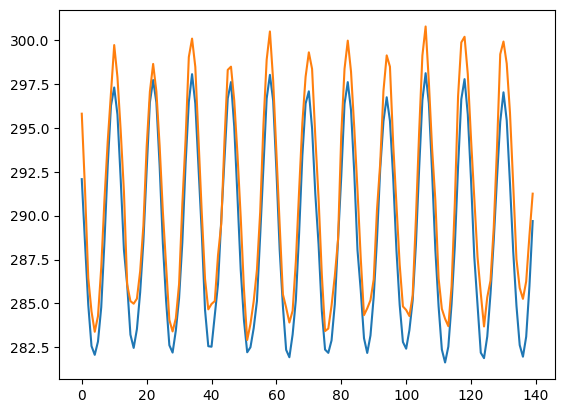

In [131]:
from matplotlib import pyplot as plt

predictions = model.predict(x_test_formatted)
predictions_df = pd.DataFrame(data=y_scaler.inverse_transform(predictions), columns=get_target()) # type: ignore
true_df = pd.DataFrame(data=y_scaler.inverse_transform(y_test_formatted), columns=get_target()) # type: ignore
plt.plot(predictions_df["soil_temperature_level_3"])
plt.plot(true_df["soil_temperature_level_3"])
true_df

In [132]:
a = model.evaluate(x=x_test_formatted, y=y_test_formatted)
print(a[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1245 - root_mean_squared_error: 0.3527 
0.3646049499511719


In [133]:
def generate_data_from_seed(
    model: Sequential,
    x_scaler: StandardScaler,
    y_scaler: StandardScaler,
    seed_data: np.ndarray,
    future_climate_data_df: pd.DataFrame,
) -> pd.DataFrame:
    """Generates climate data for year, month > seed_data.

    Args:
        model (Sequential):
        x_scaler (StandardScaler):
        y_scaler (StandardScaler):
        seed_data (np.ndarray):
        future_climate_data_df (pd.DataFrame): future data that has to start from the month after seed_data

    Returns:
        pd.DataFrame:
    """
    generated_data = []
    # (SEQ_LENGHT, len(get_features()))
    current_step = seed_data
    year_col: list[int] = []
    month_col: list[int] = []
    for index, row in future_climate_data_df.iterrows():
        year, month = cast(pd.MultiIndex, index)
        year_col.append(year)
        month_col.append(month)
        # (SEQ_LENGHT, len(get_features()))
        scaled_current_step = cast(
            np.ndarray,
            x_scaler.inverse_transform(current_step),
        )

        # (len(get_target()),)
        scaled_prediction = cast(np.ndarray, model(np.array([scaled_current_step])))[0]

        # (len(get_target()),)
        prediction = cast(
            np.ndarray, y_scaler.inverse_transform(np.array([scaled_prediction]))
        )[0]

        # (len(get_features()),)
        enriched_prediction = np.concatenate([prediction, row.to_numpy()], axis=0)
        generated_data.append(enriched_prediction)

        current_step = np.concatenate(
            [current_step[1:], np.array([enriched_prediction])]
        )

    result = pd.DataFrame(data=generated_data, columns=get_features())
    result["year"] = year_col
    result["month"] = month_col

    result = result.set_index(keys=["year", "month"], drop=True)

    return result

In [134]:
filtered_past_climate_data = past_climate_data_df[get_features()]
filtered_future_climate_data_df = future_climate_data_df.drop(
    columns=["latitude", "longitude"], errors="ignore"
)
# start generating from 1 year ago
seed_data = filtered_past_climate_data[(-12 - SEQ_LENGTH) : -12]
start_year, start_month = seed_data.index[-1]

filtered_future_climate_data_df = future_climate_data_df[
    ((future_climate_data_df.index.get_level_values("year") > start_year))
    | (
        (future_climate_data_df.index.get_level_values("year") == start_year)
        & (future_climate_data_df.index.get_level_values("month") > start_month)
    )
]

# this generated data start from one year ago
generated_data_df = generate_data_from_seed(
    model=model,
    x_scaler=x_scaler,
    y_scaler=y_scaler,
    seed_data=seed_data.to_numpy(),
    future_climate_data_df=filtered_future_climate_data_df,
)
true_data_df = past_climate_data_df[-12:]

In [135]:
def plot_values(df: pd.DataFrame, values: list[str]):
    df_reset = df.reset_index()
    df_reset["YYYY-MM"] = (
        df_reset["year"].astype(str) + "-" + df_reset["month"].astype(str).str.zfill(2)
    )
    df_reset.plot(
        x="YYYY-MM",
        y=values,
        marker="o",
    )
    plt.xlabel("Month")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

/tmp/ipykernel_253592/4066554255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data_df["cmip5_2m_temperature"] = filtered_future_climate_data_df[:12]["2m_temperature"]


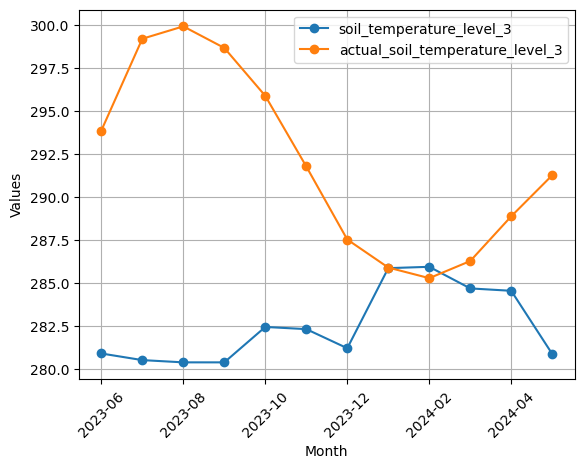

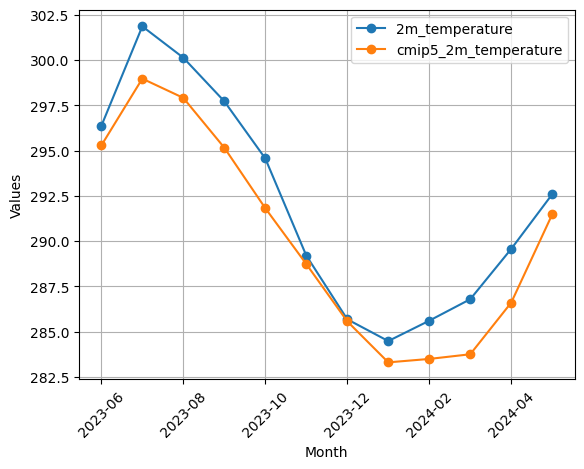

In [136]:
generated_data_df = generated_data_df[:12]
generated_data_df["actual_soil_temperature_level_3"] = true_data_df["soil_temperature_level_3"]
true_data_df["cmip5_2m_temperature"] = filtered_future_climate_data_df[:12]["2m_temperature"]
plot_values(df=generated_data_df, values=["soil_temperature_level_3", "actual_soil_temperature_level_3"])
plot_values(df=true_data_df, values=["2m_temperature", "cmip5_2m_temperature"])

In [137]:
plot_values(df=total_df, values=["volumetric_soil_water_layer_3"])

NameError: name 'total_df' is not defined